In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_color_codes('pastel')

%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.datasets import make_classification, make_regression
from sklearn.datasets import load_boston, load_iris, make_moons

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.utils import shuffle
from scipy.optimize import fmin_tnc

import warnings
warnings.filterwarnings('ignore')

In [3]:
class FlowMachine(BaseEstimator):
    
    def __init__(self, top=None, random_state=None):
        self.norm = np.linalg.norm
        self.top = top
        self.random_state = random_state
        
    def choice(self, X, theta):
        count = int(theta * len(X))
        shuffled = shuffle(
            X, random_state=self.random_state
        )
        return shuffled[:count]
    
    def unit(self, vector):
        normed = self.norm(vector)
        if not np.allclose(normed, 0):
            return np.asarray(vector) / normed
        return np.inf
    
    def construct(self, points):
        dimension = len(points[0])
        hyperplanes = []
        distances = []
        for index in range(len(points) - 1):
            distances.append((
                self.norm(points[index + 1] - points[index]),
                points[index] # store original point
            ))
        distances = sorted(distances, key=lambda value: value[0])
        for index in range(0, len(distances) - dimension):
            total = np.asarray([
                data[1] for data in distances[index:index+dimension]
            ])
            try:
                normal = np.linalg.solve(
                    total, np.ones(shape=(dimension, 1))
                ).ravel()
            except:
                # skip singular matrices
                continue
            normal = self.unit(normal)
            hyperplanes.append((
                normal,
                distances[index][1] # store one point of hyperplane
            ))
        return hyperplanes
    
    def distance(self, hyperplane, point):
        return np.abs(np.dot((point - hyperplane[1]), hyperplane[0]))
    
    def compute(self, X, planes=None):
        if planes is None:
            planes = self.hyperplanes
        vectors = []
        for x in X:
            vector = []
            for plane in planes:
                vector.append(self.distance(plane, x))
            vectors.append(vector)
        return np.asarray(vectors)
    
    def fit(self, X, y, cv=5):
        def optimization(theta):
            try:
                chosen = self.choice(X, theta)
                planes = self.construct(chosen)
                points = self.compute(X, planes)
                return cross_val_score(
                    self.top, points, y, cv=cv
                ).mean()
            except:
                return -np.inf            
        
        metric = -np.inf
        self.theta = 0.5
        for theta in np.linspace(0.1, 1, 20):
            try:
                current = optimization(theta)
                if current > metric:
                    self.theta = theta
                    metric = current
            except:                
                pass # exactly
        
        self.hyperplanes = self.construct(self.choice(X, self.theta))
        self.top.fit(self.compute(X), y)
        return self
    
    def predict(self, X):
        return self.top.predict(self.compute(X))
    
    def score(self, X, y):
        return self.top.score(self.compute(X), y)

In [4]:
folds = 5
state = 1

In [5]:
iris_data = load_iris()
boston_data = load_boston()

train_cX, test_cX, train_cy, test_cy = train_test_split(
    iris_data.data,
    iris_data.target,
    test_size=0.3,
    random_state=state
)

train_rX, test_rX, train_ry, test_ry = train_test_split(
    boston_data.data,
    boston_data.target,
    test_size=0.3,
    random_state=state
)

In [6]:
%%time

c_pred = FlowMachine(LogisticRegression(
    solver='saga', multi_class='auto'
), random_state=state).fit(
    train_cX, train_cy
).predict(test_cX)

r_pred = FlowMachine(
    LinearRegression(), random_state=state
).fit(
    train_rX, train_ry
).predict(test_rX)

Wall time: 4.13 s


In [7]:
%%time

r_base = Ridge(random_state=state).fit(
    train_rX, train_ry
).predict(test_rX)

c_base = LogisticRegression(
    solver='lbfgs', multi_class='ovr', random_state=state
).fit(
    train_cX, train_cy
).predict(test_cX)

Wall time: 12 ms


In [8]:
print("Regression MAE: %.3f, R2: %.3f" % (
    mean_absolute_error(test_ry, r_pred),
    r2_score(test_ry, r_pred)
))

print("Base MAE: %.3f, R2: %.3f" % (
    mean_absolute_error(test_ry, r_base),
    r2_score(test_ry, r_base)
))

Regression MAE: 3.857, R2: 0.694
Base MAE: 3.289, R2: 0.789


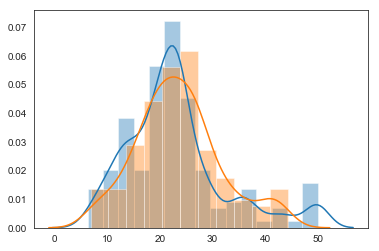

In [9]:
sns.distplot(test_ry);
sns.distplot(r_pred);

In [10]:
print(confusion_matrix(test_cy, c_pred))
print(confusion_matrix(test_cy, c_base))

[[14  0  0]
 [ 0 18  0]
 [ 0  0 13]]
[[14  0  0]
 [ 0 13  5]
 [ 0  1 12]]


In [11]:
print(classification_report(test_cy, c_pred))
print(classification_report(test_cy, c_base))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        13

   micro avg       1.00      1.00      1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.93      0.72      0.81        18
           2       0.71      0.92      0.80        13

   micro avg       0.87      0.87      0.87        45
   macro avg       0.88      0.88      0.87        45
weighted avg       0.89      0.87      0.87        45



## Second part
Synthetic datasets with cross-validation.

In [12]:
def check_regressors(X, y):
    for regressor in [
        FlowMachine(LinearRegression(), random_state=state),
        Ridge(random_state=state),
        LinearSVR(random_state=state),
        RandomForestRegressor(random_state=state),
        KNeighborsRegressor()
    ]:
        scores = cross_val_score(
            regressor,
            X=X, y=y,
            cv=KFold(folds)
        )
        
        print(type(regressor).__name__, "%.4f" % scores.mean())

In [13]:
rX, ry = make_regression(
    n_samples=100,
    n_features=2,
    n_informative=1,
    noise=5.,
    random_state=state
)

check_regressors(rX, ry)

FlowMachine 0.9136
Ridge 0.9932
LinearSVR 0.8439
RandomForestRegressor 0.9752
KNeighborsRegressor 0.9308


In [14]:
rX, ry = make_regression(
    n_samples=300,
    n_features=10,
    n_informative=8,
    noise=1.,
    random_state=state
)

check_regressors(rX, ry)

FlowMachine 0.5854
Ridge 0.9999
LinearSVR 0.9839
RandomForestRegressor 0.6722
KNeighborsRegressor 0.6902


In [15]:
rX, ry = make_regression(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    noise=1.,
    random_state=state
)

ry = np.sin(np.log(1 + ry**2))

check_regressors(rX, ry)

FlowMachine 0.7924
Ridge -0.0160
LinearSVR -0.0707
RandomForestRegressor 0.8368
KNeighborsRegressor 0.8307


In [16]:
def check_classifiers(X, y):
    for classifier in [
        FlowMachine(
            LogisticRegression(solver='saga', multi_class='auto'),
            random_state=state
        ),
        LogisticRegression(random_state=state),
        LinearSVC(random_state=state),
        RandomForestClassifier(random_state=state),
        KNeighborsClassifier()
    ]:
        scores = cross_val_score(
            classifier,
            X=X, y=y,
            scoring=make_scorer(f1_score, average='micro'),
            cv=StratifiedKFold(folds)
        )
        
        print(type(classifier).__name__, "%.4f" % scores.mean())

In [17]:
cX, cy = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_classes=5,
    weights=None,
    hypercube=False,
    random_state=state
)

check_classifiers(cX, cy)

FlowMachine 0.5008
LogisticRegression 0.3229
LinearSVC 0.3210
RandomForestClassifier 0.4031
KNeighborsClassifier 0.4110


In [18]:
cX, cy = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=5,
    n_redundant=0,
    n_classes=2,
    weights=[.1],
    hypercube=False,
    random_state=state
)

check_classifiers(cX, cy)

FlowMachine 0.9110
LogisticRegression 0.9020
LinearSVC 0.8980
RandomForestClassifier 0.8980
KNeighborsClassifier 0.9150


In [19]:
cX, cy = make_moons(
    n_samples=1000,
    noise=.5,
    random_state=state
)

check_classifiers(cX, cy)

FlowMachine 0.7930
LogisticRegression 0.7800
LinearSVC 0.7810
RandomForestClassifier 0.7810
KNeighborsClassifier 0.7850
